The world energy consumption is at its all time maximum, fossil fuels and natural gas being leading sources of energy. Towards the end of 2021, when governments were loosening the rules regarding the covid-19 pandemic, the demand for energy increased rapidly causing oil prices to steadily increase because the supply was trying to keep up. Russia is one of the leading exporters of crude oil in the world. The invasion of Russia into Ukraine has led to the imposition of sanctions over Russia by the several countries and unions (EU, UK, US, Japan, Canada). As a result, the Russian Rubble has greatly reduced in value and global oil prices have soared further.  
  
  
This analysis uses time series modelling to estimate how bad this situation can grow into if the current situation persists.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import yfinance as yf
from yahoofinancials import YahooFinancials
from datetime import datetime, timedelta, date

In [ ]:
#had to add one day because this api will return up to a day before the day you specify
today = (date.today() + timedelta(days = 1)).strftime('%Y-%m-%d')
start_date = '2022-02-01'
russian_rubble_df = yf.download('6R=F', start=start_date, end=today, progress=False, back_adjust = True, interval = '1d')
crude_oil_df = yf.download('CL=F', start=start_date, end=today, progress=False, back_adjust = True, interval = '1d')
# uae_dirham_df = yf.download('AEDUSD=X', start=start_date, end=today, progress=False, back_adjust = True, interval = '1d')

In [ ]:
def setAverages(df : pd.DataFrame) -> None:
    """Adds an average column based on high and low of the day"""
    df['Average'] = (df['High'] + df['Low']) / 2

In [ ]:
setAverages(russian_rubble_df)
setAverages(crude_oil_df)

In [ ]:
def plotHighLowAverage(df : pd.DataFrame, title : str, xlabel : str, ylabel : str) -> None:
    ax = df[['High', 'Low', 'Average']].plot(
        figsize = (12, 8),
        title = title,
        xlabel = xlabel,
        ylabel = ylabel,
        color = ('green', 'red', 'blue')
    )
    ax.xaxis.set_major_locator(mticker.FixedLocator(df.index))
    ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%b-%d')))
    ax.set_xticks(df.index)
    plt.xticks(rotation=90, ha='center')
    plt.show()

In [ ]:
title = "Prices of Russian Rubble since February"
xlabel = "Date"
ylabel = "Dollars per Rubble"
plotHighLowAverage(russian_rubble_df, title, xlabel, ylabel)

In [ ]:
title = "Prices of Crude Oil since February"
xlabel = "Date"
ylabel = "Price in dollars"
plotHighLowAverage(crude_oil_df, title, xlabel, ylabel)

From the plots, it can be clearly seen that as soon as the announcement to invade Ukraine was made (on February 24th), the prices dramatically changed. It can also be deduced that there is negative correlation between oil prices and currency value. 

In [ ]:
averages_df = pd.DataFrame(
    data =  {
                'Crude Oil' : crude_oil_df['Average'],
                'Russian Rubble' : russian_rubble_df['Average']
            }
)
averages_df['Crude Oil'].corr(averages_df['Russian Rubble'])

Indeed they are highly negatively correlated. This makes sense as crude oil is one of Russia's main export commodity. They'll have to charge more if their currency value reduces. 

It should be noted that trading does not occur on weekends so there is no data for the weekends. This can be fixed by interpolating the data points.

In [ ]:
def interpolateWeekendData(df : pd.DataFrame, start_date: str=start_date, today:str = today) -> pd.DataFrame:
    """Interpolates missing values on all columns in the data frame"""
    
    interpolated_df = pd.DataFrame(index = pd.date_range(start=start_date, end=today)[:-1])
    for col in df.columns:
        averages = []
        for row in interpolated_df.index:
            try:
                averages.append(df.loc[row][col])
            except:
                averages.append(np.nan)
        interpolated_df[col] = averages

    return interpolated_df.interpolate()

def plotManyInOne(df : pd.DataFrame) -> None:
    """plots the columns on the data frame in a single figure but as separate plots"""
    rows = df.shape[1]
    fig, axes = plt.subplots(rows, sharex=True)
    fig.set_figheight(8)
    fig.set_figwidth(12)
    for col, ax in zip(df.columns, axes):
        ax = df[col].plot(ax = ax, title=col)
        ax.xaxis.set_major_locator(mticker.FixedLocator(df.index))
        ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%b-%d')))
        ax.set_xticks(df.index)
        plt.xticks(rotation=90, ha='center')
        
    plt.show()

In [ ]:
interpolated_averages_df = interpolateWeekendData(averages_df)
plotManyInOne(interpolated_averages_df)

I wish to model crude oil prices based on the value of the russian rubble. First, a stationarity test is performed to ensure that the russian rubble data is stationary before moving to the next stage in modelling. At a given level of significance, say 5%, the data is stationary if the result of the test is less than 5%.

1

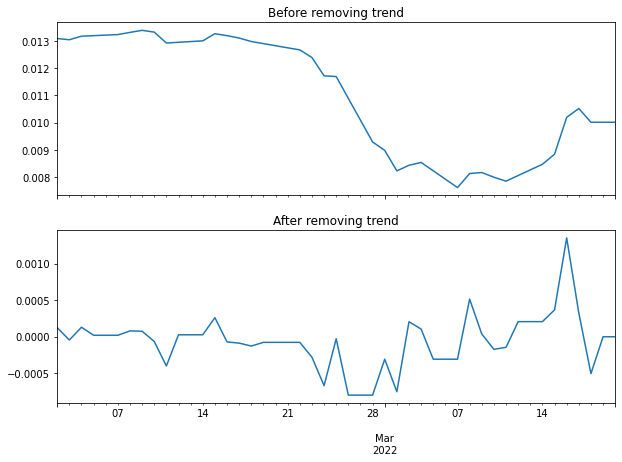

In [69]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

rr_stationary_df = interpolated_averages_df.drop(columns = ['Crude Oil'])
co_stationary_df = interpolated_averages_df.drop(columns = ['Russian Rubble'])

fig, (ax_not_removed, ax_removed) = plt.subplots(2, figsize=(10, 7), sharex=True)

dec = seasonal_decompose(rr_stationary_df, period = 1)
dec.trend.plot(ax = ax_not_removed, title = 'Before removing trend')

stationary_df = interpolated_averages_df
d = 0
while adfuller(rr_stationary_df['Russian Rubble'])[1] > 0.05:
    rr_stationary_df = rr_stationary_df.diff().dropna(axis = 0)
    d += 1
    
dec = seasonal_decompose(rr_stationary_df, period = 1)
dec.trend.plot(ax = ax_removed, title = 'After removing trend')
d

1

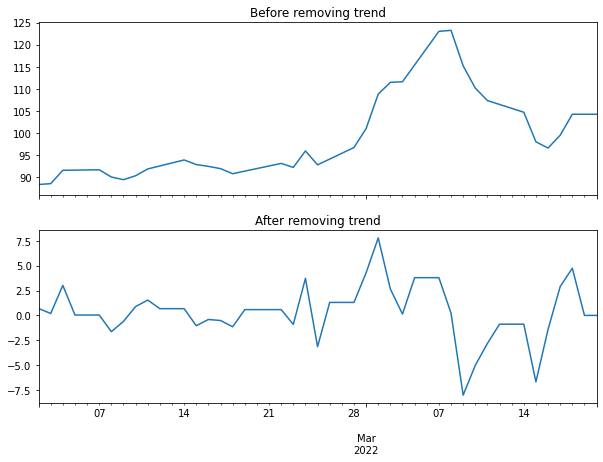

In [70]:
fig, (ax_not_removed, ax_removed) = plt.subplots(2, figsize=(10, 7), sharex=True)

dec = seasonal_decompose(co_stationary_df, period = 1)
dec.trend.plot(ax = ax_not_removed, title = 'Before removing trend')

stationary_df = interpolated_averages_df
d = 0
while adfuller(co_stationary_df['Crude Oil'])[1] > 0.05:
    co_stationary_df = co_stationary_df.diff().dropna(axis = 0)
    d += 1
    
dec = seasonal_decompose(co_stationary_df, period = 1)
dec.trend.plot(ax = ax_removed, title = 'After removing trend')
d

So the data is stationary. The next phase in modelling is to analyse the acf and pacf plots.

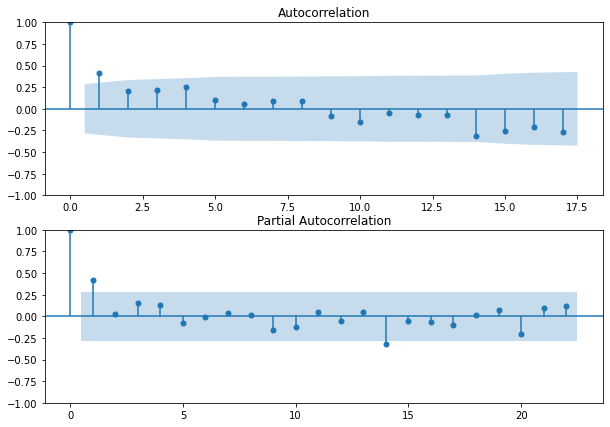

In [76]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, (ax_acf, ax_pacf) = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
plot_acf(rr_stationary_df, ax=ax_acf)
plot_pacf(rr_stationary_df, ax=ax_pacf, lags=rr_stationary_df.shape[0] / 2 - 1, method='ywm')
plt.show()

The ACF plot cuts-off at lag 1, suggesting an MA(1) while the PACF cuts off at lag 2, suggesting an AR(2). Combining this information with the number of differences that was applied, an ARIMA(1,1,1) may model russian rubble data optimally.

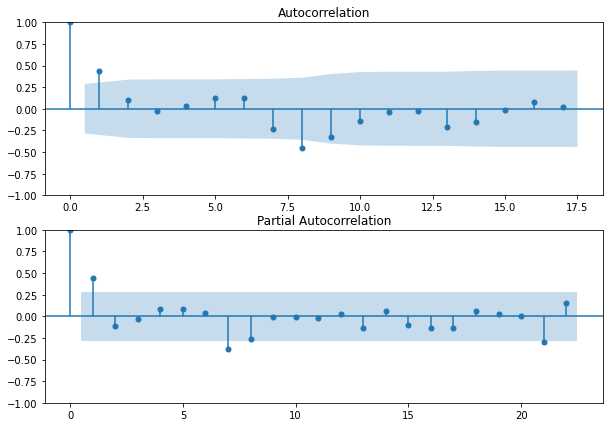

In [77]:
fig, (ax_acf, ax_pacf) = plt.subplots(2)
fig.set_figheight(7)
fig.set_figwidth(10)
plot_acf(co_stationary_df, ax=ax_acf)
plot_pacf(co_stationary_df, ax=ax_pacf, lags=co_stationary_df.shape[0] / 2 - 1, method='ywm')
plt.show()

The ACF plot cuts-off at lag 1, suggesting an MA(1) while the PACF cuts off at lag 2, suggesting an AR(2). Combining this information with the number of differences that was applied, an ARIMA(1,1,2) may model crude oil data optimally.

In [115]:
from statsmodels.tsa.arima.model import ARIMA

def findBestOrder(df : pd.DataFrame, maxp : int, d : int, maxq : int) -> tuple:
    order = [0, d, 0]
    bestOrder = tuple(order)
    minAIC = float('inf')

    for _ in range((maxp + 1) * (maxq + 1)):
        aic = ARIMA(endog = df, order = tuple(order), freq='D').fit().aic
        if aic < minAIC:
            minAIC = aic
            bestOrder = tuple(order)
            
        if order[2] == maxq:
            order[2] = 0
            order[0] += 1
        
        else:
            order[2] += 1
            
    return bestOrder

In [119]:
df = interpolated_averages_df.drop(columns = ['Crude Oil'])
order = findBestOrder(df, 1, 1, 2)
order

C:\Users\LUCAS\OneDrive\Documents\Python\Data Analysis\Jupyter Notebook\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\LUCAS\OneDrive\Documents\Python\Data Analysis\Jupyter Notebook\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\LUCAS\OneDrive\Documents\Python\Data Analysis\Jupyter Notebook\.venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0)

In [121]:
ARIMAmodel = ARIMA(endog = interpolated_averages_df['Russian Rubble'], order = order, freq='D')
ARIMAmodel = ARIMAmodel.fit()
ARIMAmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Russian Rubble   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 309.166
Date:                Sun, 20 Mar 2022   AIC                           -614.331
Time:                        23:32:41   BIC                           -610.631
Sample:                    02-01-2022   HQIC                          -612.939
                         - 03-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4363      0.123      3.543      0.000       0.195       0.678
sigma2      1.129e-07   1.68e-08      6.706      0.000    7.99e-08    1.46e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                19.28
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               8.25   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
df = interpolated_averages_df.drop(columns = ['Russian Rubble'])
order = findBestOrder(df, 1, 1, 2)
order

(1, 1, 0)

In [127]:
ARIMAmodel = ARIMA(endog = interpolated_averages_df['Crude Oil'], order = order, freq='D')
ARIMAmodel = ARIMAmodel.fit()
ARIMAmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Crude Oil   No. Observations:                   48
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -109.200
Date:                Sun, 20 Mar 2022   AIC                            222.401
Time:                        23:40:37   BIC                            226.101
Sample:                    02-01-2022   HQIC                           223.793
                         - 03-20-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4410      0.144      3.058      0.002       0.158       0.724
sigma2         6.0759      0.886      6.856      0.000       4.339       7.813
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                16.11
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               9.02   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

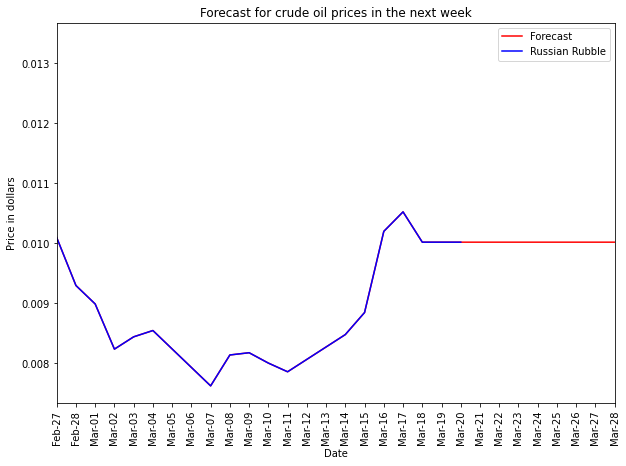

In [125]:

future_dates = [pd.to_datetime(today) + timedelta(days = x) for x in range(0, 8)]
dates = pd.to_datetime(list(interpolated_averages_df.index.values) + future_dates)
forecast_df = pd.DataFrame(index=dates, data = interpolated_averages_df['Russian Rubble'])
forecast_df['Forecast'] = ARIMAmodel.predict(start = future_dates[0], end = dates[-1])
forecast_df['Forecast'] = forecast_df['Forecast'].fillna(forecast_df['Russian Rubble'])
ax_co = forecast_df[['Forecast', 'Russian Rubble']].plot(
    title = "Forecast for Russian Rubble in the next week",
    figsize = (10, 7),
    color = ('red', 'blue'),
    xlabel = 'Date',
    ylabel = 'Price in dollars'
)
ax_co.xaxis.set_major_locator(mticker.FixedLocator(forecast_df.index))
ax_co.xaxis.set_major_formatter(mticker.FixedFormatter(forecast_df.index.strftime('%b-%d')))
ax_co.set_xticks(forecast_df.index)
ax_co.set_xlim((forecast_df.index[-30], forecast_df.index[-1]))
plt.xticks(rotation=90, ha='center')
plt.show()

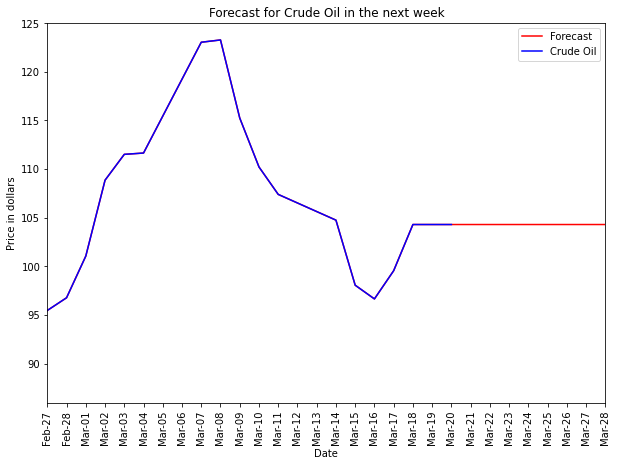

In [128]:
future_dates = [pd.to_datetime(today) + timedelta(days = x) for x in range(0, 8)]
dates = pd.to_datetime(list(interpolated_averages_df.index.values) + future_dates)
forecast_df = pd.DataFrame(index=dates, data = interpolated_averages_df['Crude Oil'])
forecast_df['Forecast'] = ARIMAmodel.predict(start = future_dates[0], end = dates[-1])
forecast_df['Forecast'] = forecast_df['Forecast'].fillna(forecast_df['Crude Oil'])
ax_co = forecast_df[['Forecast', 'Crude Oil']].plot(
    title = "Forecast for Crude Oil in the next week",
    figsize = (10, 7),
    color = ('red', 'blue'),
    xlabel = 'Date',
    ylabel = 'Price in dollars'
)
ax_co.xaxis.set_major_locator(mticker.FixedLocator(forecast_df.index))
ax_co.xaxis.set_major_formatter(mticker.FixedFormatter(forecast_df.index.strftime('%b-%d')))
ax_co.set_xticks(forecast_df.index)
ax_co.set_xlim((forecast_df.index[-30], forecast_df.index[-1]))
plt.xticks(rotation=90, ha='center')
plt.show()